# Check if Cooling is correct for 0.2Zsol background

In [1]:

import _init_
from constants import *
from set_path import *
from config import *
from functions import *

In [10]:

file = '/g/data/jh2/av5889/quokka_myrepo/quokka/extern/grackle_data_files/input/CloudyData_UVB=HM2012.h5'
# file = '/g/data/jh2/av5889/quokka_myrepo/quokka/extern/grackle_data_files/input/CloudyData_UVB=FG2011.h5'
#Dim2 is redshift. Dim1 is density. Dim3 is temperature
grackle = h5py.File(file)
array = grackle['CoolingRates/Primordial/MMW'][()]
#density(1.e-6, 1.e4), redshift(0,15), temperature(10., 1.e9)
table = array[:,0,:]
table_nH   = np.logspace(-10, 4, array.shape[0])
table_temp = np.logspace(1,  9, array.shape[2])

prim_heating = grackle['CoolingRates/Primordial/Heating'][()][:,0,:]
prim_cooling = grackle['CoolingRates/Primordial/Cooling'][()][:,0,:]

met_heating  = grackle['CoolingRates/Metals/Heating'][()][:,0,:]
met_cooling  = grackle['CoolingRates/Metals/Cooling'][()][:,0,:]

netLambda_prim = prim_heating - prim_cooling 

netLambda_met  = met_heating - met_cooling
netLambda_Zsol = netLambda_prim + netLambda_met

Zbg = 0.2
netLambda_met  = met_heating - Zbg*met_cooling
netLambda_02Zsol = netLambda_prim + netLambda_met

In [11]:
LambdaZsol = interpolate.interp2d(table_temp, table_nH, netLambda_Zsol,\
                              kind='linear', copy=True, bounds_error=False, fill_value=None)
Lambda02Zsol = interpolate.interp2d(table_temp, table_nH, netLambda_02Zsol,\
                              kind='linear', copy=True, bounds_error=False, fill_value=None)

In [12]:
Lambda02Zsol(6.71e+03, 4.19e-24/mp),LambdaZsol(6.71e+03, 4.19e-24/mp)

(array([-1.28994298e-26]), array([-2.99885697e-25]))

In [13]:

from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# Example arrays of x values and corresponding f(x) values


# Define a function that returns f(x) for a given x
def fZsol(T,netLambda):
    x_values = table_temp
    interp_func = interp1d(x_values, netLambda, kind='linear')
    return interp_func(T)

def f02Zsol(T,netLambda):
    x_values = table_temp
    interp_func = interp1d(x_values, netLambda, kind='linear',fill_value="extrapolate")
    return interp_func(T)


i=0
teq = np.zeros(table_nH.shape[0])
teq_02Zsol = np.zeros(table_nH.shape[0])
teq_prev = 10.
guess = np.logspace(1,  9, array.shape[0])

for i in range(netLambda_02Zsol.shape[0]):
#     teq_02Zsol[i] = fsolve(f02Zsol, table_temp[i], args=(np.abs(netLambda_02Zsol[i])))
    teq[i] = fsolve(fZsol, table_temp[i], args=(np.abs(netLambda_Zsol[i])))

/apps/python3/3.9.2/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/apps/python3/3.9.2/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [14]:
for i in range(netLambda_02Zsol.shape[0]):
#     print(table_temp[i])
    teq_02Zsol[i] = fsolve(f02Zsol, table_temp[i], args=(np.abs(netLambda_02Zsol[i])))

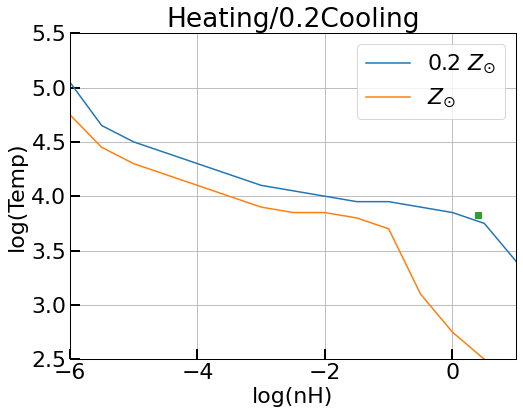

In [16]:
fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.02},figsize=(8, 6))
ax.plot(np.log10(table_nH), np.log10(teq_02Zsol), label=r'%.1f $Z_{\odot}$'%(Zbg))
ax.plot(np.log10(table_nH), np.log10(teq), label=r'$Z_{\odot}$')
ax.plot(np.log10(4.19e-24/mp), np.log10(6.71e3), 's')
ax.set_xlim(-6, 1.)
ax.set_ylim(2.5, 5.5)
ax.grid()
ax.set_ylabel('log(Temp)')
ax.set_xlabel('log(nH)')
ax.set_title('Heating/0.2Cooling')
ax.legend()

# Get Mu

In [22]:

i=0
bins = 100
egas_arr = np.logspace(-21., -5., bins)
nH_arr   = np.logspace(-6.0, 4.0, int(bins))
T = np.zeros((egas_arr.shape[0],nH_arr.shape[0]))

for egas in egas_arr:
    j=0
    for nH in nH_arr:
        C = (gamma - 1.) * egas / (boltzmann_constant_cgs*nH)
        minT = C*np.amin(table)
        maxT = C*np.amax(table)
        def func(T):
            mu = interpolate.interp2d(table_temp, table_nH, table,\
                              kind='linear', copy=True, bounds_error=False, fill_value=None)
            return C*mu(T,nH)[0] - T

        T[i,j] = scipy.optimize.toms748(func, minT, maxT)
        j+=1
    i+=1

    
# temperature_table = interpolate.RectBivariateSpline(egas_arr, nH_arr, T)


In [23]:
mu_interp = interpolate.interp2d(table_temp, table_nH, table,\
                              kind='linear', copy=True, bounds_error=False, fill_value=None)

In [24]:
cloudy_H_mass_fraction = 1. / (1. + 0.1 * 3.971)
X = cloudy_H_mass_fraction
Z  =  0.02*Zbg
Y = 1. - X - Z
mean_metals_A = 16.
sigma_T = 6.6524e-25
T_cmb = 2.725
E_cmb = 7.5e-15 * (T_cmb * T_cmb * T_cmb * T_cmb)
electron_mass_cgs = m_e = 9.1e-28
rho = 4.19e-24
rhoH = rho * cloudy_H_mass_fraction
nH =  rhoH / (mp + m_e)
T = 6.71e+03

# Photoelectric Heating

In [25]:
Tsqrt = np.sqrt(T);
phi = 0.5
G_0 = 1.7
mu  = mu_interp(6.71e+03, nH)
metarr = np.linspace(0.2, 2., 10)
Gamma_pe = np.zeros(10)
i=0
for Zbg in metarr:
    Z = 0.02*Zbg
    n_e = (rho / (mp + m_e)) * (1.0 - mu * (X + Y / 4. + Z / mean_metals_A)) / (mu - (electron_mass_cgs / (mp + m_e)))
    epsilon = 4.9e-2 / (1. + 4.0e-3 * np.power(G_0 * Tsqrt / (n_e * phi), 0.73)) +\
         3.7e-2 * np.power(T / 1.0e4, 0.7) / (1. + 2.0e-4 * (G_0 * Tsqrt / (n_e * phi)));
    Gamma_pe[i] = 1.3e-24 * nH * epsilon * G_0
    i+=1


In [31]:
c_light_cgs_ = 3.e10
compton_CMB= np.zeros(10)
i=0
for Zbg in metarr:
    Z = 0.02*Zbg
    n_e = (rho / (mp + m_e)) * (1.0 - mu * (X + Y / 4. + Z / mean_metals_A))/(mu - (electron_mass_cgs / (mp + m_e)))
    Gamma_C = (8. * sigma_T * E_cmb) / (3. * electron_mass_cgs * c_light_cgs_)
    C_n = Gamma_C * boltzmann_constant_cgs / (5. / 3. - 1.0)
    compton_CMB[i] = -C_n * (T - T_cmb) * n_e
    i+=1

In [ ]:
np.abs(Lambda02Zsol(T, nH)/Gamma_pe[0])

In [62]:
LambdaZsol(T, nH)/Gamma_pe[0]

array([-1.61964945])

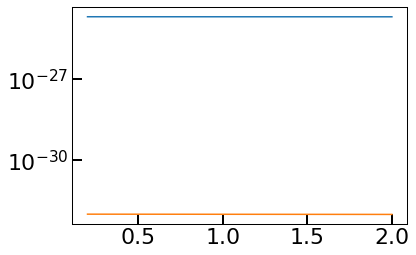

In [35]:
plt.plot(metarr, Gamma_pe)
plt.plot(metarr, np.abs(compton_CMB))
plt.yscale('log')
# plt.ylim(2., 2.5)